## Preliminary data exploration

To choose the features we use in our first model, we do a brief exploratory analysis here. First, let's import the relevant libraries:

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [4]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprice_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprice_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [14]:
houseprice_df.isnull().sum()/houseprice_df.shape[0]*100

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

In [55]:
# drop columns with more than 10% missing values
houseprice_df2 = houseprice_df.loc[:, houseprice_df.isnull().sum()/houseprice_df.shape[0] < 0.1]
print('{} columns dropped'.format(houseprice_df.shape[1] - houseprice_df2.shape[1]))

6 columns dropped


In [56]:
houseprice_df2.isnull().sum()/houseprice_df2.shape[0]*100

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotarea          0.000000
street           0.000000
lotshape         0.000000
landcontour      0.000000
utilities        0.000000
lotconfig        0.000000
landslope        0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
bldgtype         0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
yearbuilt        0.000000
yearremodadd     0.000000
roofstyle        0.000000
roofmatl         0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrtype       0.547945
masvnrarea       0.547945
exterqual        0.000000
extercond        0.000000
foundation       0.000000
bsmtqual         2.534247
bsmtcond         2.534247
                   ...   
bsmtfullbath     0.000000
bsmthalfbath     0.000000
fullbath         0.000000
halfbath         0.000000
bedroomabvgr     0.000000
kitchenabvgr     0.000000
kitchenqual      0.000000
totrmsabvgrd

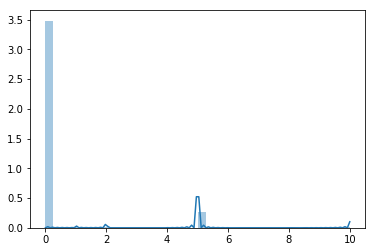

In [57]:
sns.distplot(houseprice_df2.isnull().sum(axis=1))

In [58]:
# drop rows with more than 2 missing values

houseprice_df3 = houseprice_df2.loc[houseprice_df2.isnull().sum(axis=1) < 3 ,:]
print('{} out of {} rows dropped'.format(houseprice_df2.shape[0] - houseprice_df3.shape[0], houseprice_df2.shape[0]))

111 out of 1460 rows dropped


In [59]:
(houseprice_df3.isnull().sum()/houseprice_df3.shape[0]*100 > 0.1).sum()

2

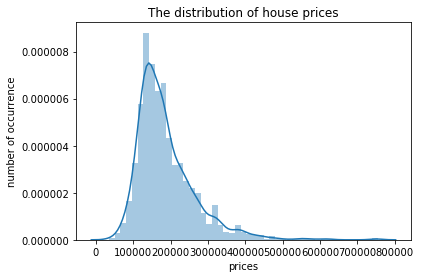

In [30]:
sns.distplot(houseprice_df3.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("prices")
plt.ylabel("number of occurrence")
plt.show()

At first glance, overall quality and total number of rooms  may play an important role in the house price. Let's look at whether we see some differences in sale price among houses with different building quality and num of rooms:

# show correlation matrix for the 5 most correlated features and choose a couple that don't have collinearity

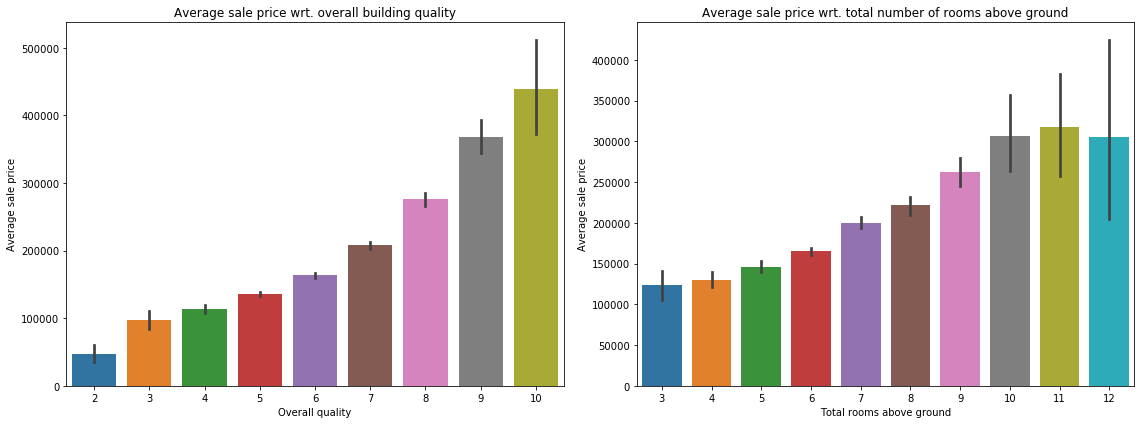

In [96]:
plt.figure(figsize=(16,6))


plt.subplot(1,2,1)
sns.barplot(x='overallqual', y='saleprice', data=houseprice_df3)
plt.title('Average sale price wrt. overall building quality')
plt.ylabel('Average sale price')
plt.xlabel('Overall quality')

plt.subplot(1,2,2)
sns.barplot(x='totrmsabvgrd', y='saleprice', data=houseprice_df3)
plt.title('Average sale price wrt. total number of rooms above ground')
plt.ylabel('Average sale price')
plt.xlabel('Total rooms above ground')

plt.tight_layout()
plt.show()


As can be seen in the graph, the average sale price seem to be different between each group. That is to say, on average, houses with more above ground rooms and better overall quality tend to sell for more.

## An initial model for house sale prices

Simple linear regression model and estimate it using OLS. Will use both scikit-learn and statsmodels for the sake of practice.

In [93]:
#SciKit Learn Model

target = houseprice_df3[['saleprice']]
data = houseprice_df3[['overallqual', 'totrmsabvgrd']]

# Initialize linear regression model
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(target, data)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[1.31685603e-05]
 [1.09925418e-05]]

Intercept: 
 [3.76275068 4.4946094 ]


`LinearRegression()`'s `fit()` method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ charges = 3.76 + 4.49 + 1.31685603e-05  *overallqual + 1.09925418e-05  *totrmsabvgrd \qquad$$

In [101]:
# StatsModels model

data = sm.add_constant(data)

results = sm.OLS(target, data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1351.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):          1.73e-322
Time:                        13:43:19   Log-Likelihood:                -16384.
No. Observations:                1349   AIC:                         3.277e+04
Df Residuals:                    1346   BIC:                         3.279e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.456e+05   6618.735    -21.994      0.000   -1.59e+05   -1.33e+05
overallqual   4.014e+04   1042.487     38.503      0.000    3.81e+04    4.22e+04
totrmsabvgrd  1.263e+04    873.354     14.464      0.000    1.09e+04    1.43e+04
==============================================================================
Omnibus:                      491.908   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5353.447
Skew:                           1.373   Prob(JB):                         0.00
Kurtosis:                      12.365   Cond. No.                         49.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The two models are inconsistent. SciKit Learn return two inte